In [110]:
import torch
import torchvision
import torch.nn as nn
import numpy as np 
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim

In [123]:
loader = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()])

def imageLoader(directory):
    return loader(Image.open(directory)).unsqueeze(0).to(torch.float)
style = imageLoader("./style.jpg")
content = imageLoader("./content.jpg")

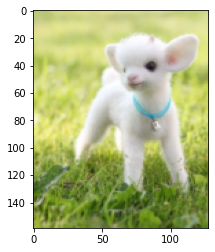

In [124]:

def imageshow(tensor):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
imageshow(content)


In [16]:
torch.utils.model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth', model_dir='/results/')
    

OrderedDict([('features.0.weight',
              tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
                        [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
                        [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],
              
                       [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
                        [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
                        [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],
              
                       [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
                        [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
                        [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],
              
              
                      [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
                        [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
                        [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],
              
                       [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
                        [ 3.7836e-01, -2

In [21]:
vgg = models.vgg19()
vgg.load_state_dict(torch.utils.model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth', model_dir='/results/'))
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [22]:
for parameter in vgg.parameters():
  parameter.requires_grad_(False)

In [31]:
for i, layer in enumerate(vgg.features):
    if isinstance(layer,torch.nn.MaxPool2d):
        vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

In [112]:
def get_features(img,model):
    layers = {'0': 'conv1_1','5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content layer
              '28': 'conv5_1'}

    feature = {}
    x = img
    for i , layer in enumerate(vgg.features):
        if str(i) in layers:
            x = layer(x)
            feature[layers[str(i)]] = x
    return feature

content_features = get_features(content,vgg)
style_features = get_features(style,vgg)

In [100]:
def gramMatrix(tensor):
    _,nC,nH,nW = tensor.size()
    tensor = tensor.view(nC,nH*nW)
    tensor = torch.mm(tensor, tensor.t())
    return tensor


style_grams = {
  layer: gramMatrix(style_features[layer]) for layer in style_features}


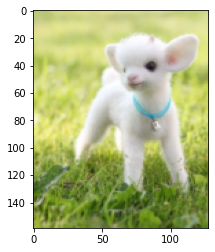

In [125]:
# target = torch.randn_like(content).requires_grad_(True)
target = content.clone().requires_grad_(True)
imageshow(target)

In [102]:
target_features = get_features(target,vgg)
target_grams = {
  layer: gramMatrix(target_features[layer]) for layer in target_features}

torch.Size([1, 64, 159, 128])
torch.Size([1, 128, 159, 128])
torch.Size([1, 256, 159, 128])
torch.Size([1, 512, 159, 128])
torch.Size([1, 512, 159, 128])
torch.Size([1, 512, 159, 128])


In [98]:
def calculateContent(target_features,content_features):
    _,c,h,w = content_features["conv4_2"].size()
    return torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)

calculateContent(target_features,content_features)

tensor(362.2788, grad_fn=<MeanBackward0>)

In [108]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
def calculateStyle(style_grams,target_grams,target_features,style_weights):
    loss = 0
    for layer in style_weights:
        _, d, h, w = target_features[layer].shape
        layer_loss = torch.mean((style_grams[layer] - target_grams[layer]) ** 2) / (d * h * w)
        loss += layer_loss * style_weights[layer]
        
    return loss

calculateStyle(style_grams,target_grams,target_features,style_weights)

tensor(1.4508e+09, grad_fn=<AddBackward0>)

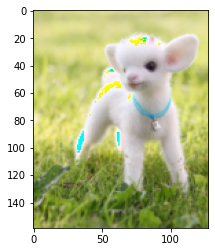

tensor(3.3979e+10, grad_fn=<AddBackward0>)
tensor(2.9157e+10, grad_fn=<AddBackward0>)
tensor(2.4507e+10, grad_fn=<AddBackward0>)
tensor(2.0096e+10, grad_fn=<AddBackward0>)
tensor(1.5996e+10, grad_fn=<AddBackward0>)
tensor(1.2280e+10, grad_fn=<AddBackward0>)
tensor(9.0248e+09, grad_fn=<AddBackward0>)
tensor(6.3000e+09, grad_fn=<AddBackward0>)
tensor(4.1666e+09, grad_fn=<AddBackward0>)
tensor(2.6650e+09, grad_fn=<AddBackward0>)
tensor(1.8032e+09, grad_fn=<AddBackward0>)
tensor(1.5424e+09, grad_fn=<AddBackward0>)
tensor(1.7857e+09, grad_fn=<AddBackward0>)
tensor(2.3789e+09, grad_fn=<AddBackward0>)
tensor(3.1285e+09, grad_fn=<AddBackward0>)
tensor(3.8397e+09, grad_fn=<AddBackward0>)
tensor(4.3581e+09, grad_fn=<AddBackward0>)
tensor(4.5967e+09, grad_fn=<AddBackward0>)
tensor(4.5405e+09, grad_fn=<AddBackward0>)
tensor(4.2313e+09, grad_fn=<AddBackward0>)


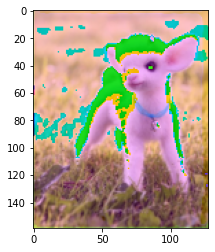

tensor(3.7453e+09, grad_fn=<AddBackward0>)
tensor(3.1706e+09, grad_fn=<AddBackward0>)
tensor(2.5904e+09, grad_fn=<AddBackward0>)
tensor(2.0715e+09, grad_fn=<AddBackward0>)
tensor(1.6585e+09, grad_fn=<AddBackward0>)
tensor(1.3730e+09, grad_fn=<AddBackward0>)
tensor(1.2154e+09, grad_fn=<AddBackward0>)
tensor(1.1695e+09, grad_fn=<AddBackward0>)
tensor(1.2082e+09, grad_fn=<AddBackward0>)
tensor(1.2993e+09, grad_fn=<AddBackward0>)
tensor(1.4110e+09, grad_fn=<AddBackward0>)
tensor(1.5154e+09, grad_fn=<AddBackward0>)
tensor(1.5918e+09, grad_fn=<AddBackward0>)
tensor(1.6274e+09, grad_fn=<AddBackward0>)
tensor(1.6173e+09, grad_fn=<AddBackward0>)
tensor(1.5642e+09, grad_fn=<AddBackward0>)
tensor(1.4760e+09, grad_fn=<AddBackward0>)
tensor(1.3645e+09, grad_fn=<AddBackward0>)
tensor(1.2432e+09, grad_fn=<AddBackward0>)
tensor(1.1253e+09, grad_fn=<AddBackward0>)


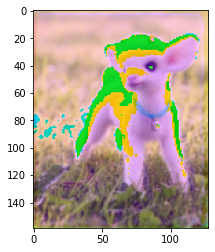

tensor(1.0223e+09, grad_fn=<AddBackward0>)
tensor(9.4211e+08, grad_fn=<AddBackward0>)
tensor(8.8868e+08, grad_fn=<AddBackward0>)
tensor(8.6170e+08, grad_fn=<AddBackward0>)
tensor(8.5706e+08, grad_fn=<AddBackward0>)
tensor(8.6787e+08, grad_fn=<AddBackward0>)
tensor(8.8591e+08, grad_fn=<AddBackward0>)
tensor(9.0315e+08, grad_fn=<AddBackward0>)
tensor(9.1312e+08, grad_fn=<AddBackward0>)
tensor(9.1182e+08, grad_fn=<AddBackward0>)
tensor(8.9812e+08, grad_fn=<AddBackward0>)
tensor(8.7349e+08, grad_fn=<AddBackward0>)
tensor(8.4132e+08, grad_fn=<AddBackward0>)
tensor(8.0596e+08, grad_fn=<AddBackward0>)
tensor(7.7176e+08, grad_fn=<AddBackward0>)
tensor(7.4226e+08, grad_fn=<AddBackward0>)
tensor(7.1963e+08, grad_fn=<AddBackward0>)
tensor(7.0456e+08, grad_fn=<AddBackward0>)
tensor(6.9634e+08, grad_fn=<AddBackward0>)
tensor(6.9324e+08, grad_fn=<AddBackward0>)


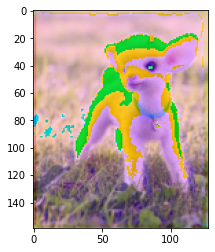

tensor(6.9303e+08, grad_fn=<AddBackward0>)
tensor(6.9343e+08, grad_fn=<AddBackward0>)
tensor(6.9256e+08, grad_fn=<AddBackward0>)
tensor(6.8917e+08, grad_fn=<AddBackward0>)
tensor(6.8279e+08, grad_fn=<AddBackward0>)
tensor(6.7369e+08, grad_fn=<AddBackward0>)
tensor(6.6266e+08, grad_fn=<AddBackward0>)
tensor(6.5082e+08, grad_fn=<AddBackward0>)
tensor(6.3933e+08, grad_fn=<AddBackward0>)
tensor(6.2916e+08, grad_fn=<AddBackward0>)
tensor(6.2092e+08, grad_fn=<AddBackward0>)
tensor(6.1480e+08, grad_fn=<AddBackward0>)
tensor(6.1059e+08, grad_fn=<AddBackward0>)
tensor(6.0777e+08, grad_fn=<AddBackward0>)
tensor(6.0568e+08, grad_fn=<AddBackward0>)
tensor(6.0365e+08, grad_fn=<AddBackward0>)
tensor(6.0115e+08, grad_fn=<AddBackward0>)
tensor(5.9790e+08, grad_fn=<AddBackward0>)
tensor(5.9385e+08, grad_fn=<AddBackward0>)
tensor(5.8918e+08, grad_fn=<AddBackward0>)


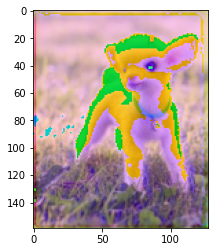

tensor(5.8419e+08, grad_fn=<AddBackward0>)
tensor(5.7926e+08, grad_fn=<AddBackward0>)
tensor(5.7470e+08, grad_fn=<AddBackward0>)
tensor(5.7072e+08, grad_fn=<AddBackward0>)
tensor(5.6738e+08, grad_fn=<AddBackward0>)
tensor(5.6463e+08, grad_fn=<AddBackward0>)
tensor(5.6231e+08, grad_fn=<AddBackward0>)
tensor(5.6021e+08, grad_fn=<AddBackward0>)
tensor(5.5813e+08, grad_fn=<AddBackward0>)
tensor(5.5593e+08, grad_fn=<AddBackward0>)
tensor(5.5352e+08, grad_fn=<AddBackward0>)
tensor(5.5090e+08, grad_fn=<AddBackward0>)
tensor(5.4815e+08, grad_fn=<AddBackward0>)
tensor(5.4534e+08, grad_fn=<AddBackward0>)
tensor(5.4260e+08, grad_fn=<AddBackward0>)
tensor(5.4001e+08, grad_fn=<AddBackward0>)
tensor(5.3761e+08, grad_fn=<AddBackward0>)
tensor(5.3540e+08, grad_fn=<AddBackward0>)
tensor(5.3336e+08, grad_fn=<AddBackward0>)
tensor(5.3143e+08, grad_fn=<AddBackward0>)


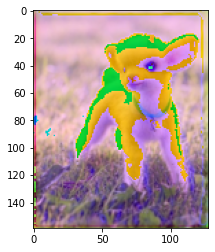

tensor(5.2953e+08, grad_fn=<AddBackward0>)
tensor(5.2761e+08, grad_fn=<AddBackward0>)
tensor(5.2564e+08, grad_fn=<AddBackward0>)
tensor(5.2361e+08, grad_fn=<AddBackward0>)
tensor(5.2152e+08, grad_fn=<AddBackward0>)
tensor(5.1941e+08, grad_fn=<AddBackward0>)
tensor(5.1732e+08, grad_fn=<AddBackward0>)
tensor(5.1527e+08, grad_fn=<AddBackward0>)
tensor(5.1328e+08, grad_fn=<AddBackward0>)
tensor(5.1135e+08, grad_fn=<AddBackward0>)
tensor(5.0948e+08, grad_fn=<AddBackward0>)
tensor(5.0763e+08, grad_fn=<AddBackward0>)
tensor(5.0580e+08, grad_fn=<AddBackward0>)
tensor(5.0396e+08, grad_fn=<AddBackward0>)
tensor(5.0210e+08, grad_fn=<AddBackward0>)
tensor(5.0023e+08, grad_fn=<AddBackward0>)
tensor(4.9834e+08, grad_fn=<AddBackward0>)
tensor(4.9645e+08, grad_fn=<AddBackward0>)
tensor(4.9457e+08, grad_fn=<AddBackward0>)
tensor(4.9270e+08, grad_fn=<AddBackward0>)


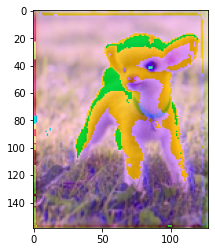

tensor(4.9085e+08, grad_fn=<AddBackward0>)
tensor(4.8902e+08, grad_fn=<AddBackward0>)
tensor(4.8720e+08, grad_fn=<AddBackward0>)
tensor(4.8540e+08, grad_fn=<AddBackward0>)
tensor(4.8359e+08, grad_fn=<AddBackward0>)
tensor(4.8179e+08, grad_fn=<AddBackward0>)
tensor(4.7997e+08, grad_fn=<AddBackward0>)
tensor(4.7815e+08, grad_fn=<AddBackward0>)
tensor(4.7633e+08, grad_fn=<AddBackward0>)
tensor(4.7451e+08, grad_fn=<AddBackward0>)
tensor(4.7269e+08, grad_fn=<AddBackward0>)
tensor(4.7088e+08, grad_fn=<AddBackward0>)
tensor(4.6908e+08, grad_fn=<AddBackward0>)
tensor(4.6728e+08, grad_fn=<AddBackward0>)
tensor(4.6549e+08, grad_fn=<AddBackward0>)
tensor(4.6370e+08, grad_fn=<AddBackward0>)
tensor(4.6191e+08, grad_fn=<AddBackward0>)
tensor(4.6012e+08, grad_fn=<AddBackward0>)
tensor(4.5833e+08, grad_fn=<AddBackward0>)
tensor(4.5654e+08, grad_fn=<AddBackward0>)


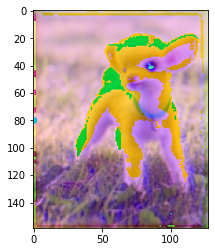

tensor(4.5476e+08, grad_fn=<AddBackward0>)
tensor(4.5298e+08, grad_fn=<AddBackward0>)
tensor(4.5120e+08, grad_fn=<AddBackward0>)
tensor(4.4942e+08, grad_fn=<AddBackward0>)
tensor(4.4765e+08, grad_fn=<AddBackward0>)
tensor(4.4589e+08, grad_fn=<AddBackward0>)
tensor(4.4412e+08, grad_fn=<AddBackward0>)
tensor(4.4236e+08, grad_fn=<AddBackward0>)
tensor(4.4060e+08, grad_fn=<AddBackward0>)
tensor(4.3885e+08, grad_fn=<AddBackward0>)
tensor(4.3709e+08, grad_fn=<AddBackward0>)
tensor(4.3534e+08, grad_fn=<AddBackward0>)
tensor(4.3359e+08, grad_fn=<AddBackward0>)
tensor(4.3185e+08, grad_fn=<AddBackward0>)
tensor(4.3011e+08, grad_fn=<AddBackward0>)
tensor(4.2837e+08, grad_fn=<AddBackward0>)
tensor(4.2664e+08, grad_fn=<AddBackward0>)
tensor(4.2491e+08, grad_fn=<AddBackward0>)
tensor(4.2319e+08, grad_fn=<AddBackward0>)
tensor(4.2146e+08, grad_fn=<AddBackward0>)


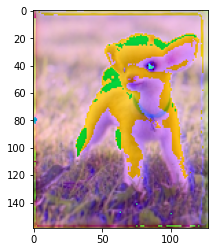

tensor(4.1975e+08, grad_fn=<AddBackward0>)
tensor(4.1803e+08, grad_fn=<AddBackward0>)
tensor(4.1633e+08, grad_fn=<AddBackward0>)
tensor(4.1462e+08, grad_fn=<AddBackward0>)
tensor(4.1292e+08, grad_fn=<AddBackward0>)
tensor(4.1123e+08, grad_fn=<AddBackward0>)
tensor(4.0954e+08, grad_fn=<AddBackward0>)
tensor(4.0785e+08, grad_fn=<AddBackward0>)
tensor(4.0617e+08, grad_fn=<AddBackward0>)
tensor(4.0449e+08, grad_fn=<AddBackward0>)
tensor(4.0282e+08, grad_fn=<AddBackward0>)
tensor(4.0115e+08, grad_fn=<AddBackward0>)
tensor(3.9949e+08, grad_fn=<AddBackward0>)
tensor(3.9783e+08, grad_fn=<AddBackward0>)
tensor(3.9618e+08, grad_fn=<AddBackward0>)
tensor(3.9453e+08, grad_fn=<AddBackward0>)
tensor(3.9289e+08, grad_fn=<AddBackward0>)
tensor(3.9126e+08, grad_fn=<AddBackward0>)
tensor(3.8962e+08, grad_fn=<AddBackward0>)
tensor(3.8800e+08, grad_fn=<AddBackward0>)


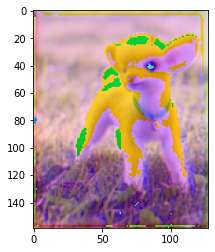

tensor(3.8638e+08, grad_fn=<AddBackward0>)
tensor(3.8476e+08, grad_fn=<AddBackward0>)
tensor(3.8316e+08, grad_fn=<AddBackward0>)
tensor(3.8155e+08, grad_fn=<AddBackward0>)
tensor(3.7996e+08, grad_fn=<AddBackward0>)
tensor(3.7836e+08, grad_fn=<AddBackward0>)
tensor(3.7678e+08, grad_fn=<AddBackward0>)
tensor(3.7520e+08, grad_fn=<AddBackward0>)
tensor(3.7362e+08, grad_fn=<AddBackward0>)
tensor(3.7206e+08, grad_fn=<AddBackward0>)
tensor(3.7050e+08, grad_fn=<AddBackward0>)
tensor(3.6894e+08, grad_fn=<AddBackward0>)
tensor(3.6739e+08, grad_fn=<AddBackward0>)
tensor(3.6585e+08, grad_fn=<AddBackward0>)
tensor(3.6431e+08, grad_fn=<AddBackward0>)
tensor(3.6278e+08, grad_fn=<AddBackward0>)
tensor(3.6126e+08, grad_fn=<AddBackward0>)
tensor(3.5974e+08, grad_fn=<AddBackward0>)
tensor(3.5823e+08, grad_fn=<AddBackward0>)
tensor(3.5673e+08, grad_fn=<AddBackward0>)


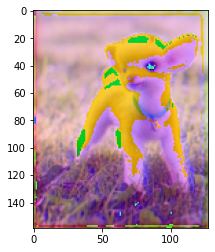

tensor(3.5523e+08, grad_fn=<AddBackward0>)
tensor(3.5374e+08, grad_fn=<AddBackward0>)
tensor(3.5226e+08, grad_fn=<AddBackward0>)
tensor(3.5078e+08, grad_fn=<AddBackward0>)
tensor(3.4931e+08, grad_fn=<AddBackward0>)
tensor(3.4785e+08, grad_fn=<AddBackward0>)
tensor(3.4639e+08, grad_fn=<AddBackward0>)
tensor(3.4494e+08, grad_fn=<AddBackward0>)
tensor(3.4350e+08, grad_fn=<AddBackward0>)
tensor(3.4206e+08, grad_fn=<AddBackward0>)
tensor(3.4064e+08, grad_fn=<AddBackward0>)
tensor(3.3921e+08, grad_fn=<AddBackward0>)
tensor(3.3780e+08, grad_fn=<AddBackward0>)
tensor(3.3639e+08, grad_fn=<AddBackward0>)
tensor(3.3500e+08, grad_fn=<AddBackward0>)
tensor(3.3360e+08, grad_fn=<AddBackward0>)
tensor(3.3222e+08, grad_fn=<AddBackward0>)
tensor(3.3084e+08, grad_fn=<AddBackward0>)
tensor(3.2947e+08, grad_fn=<AddBackward0>)
tensor(3.2811e+08, grad_fn=<AddBackward0>)


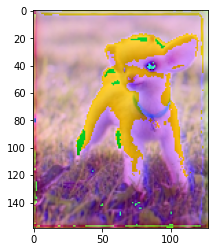

tensor(3.2675e+08, grad_fn=<AddBackward0>)
tensor(3.2541e+08, grad_fn=<AddBackward0>)
tensor(3.2407e+08, grad_fn=<AddBackward0>)
tensor(3.2273e+08, grad_fn=<AddBackward0>)
tensor(3.2141e+08, grad_fn=<AddBackward0>)
tensor(3.2009e+08, grad_fn=<AddBackward0>)
tensor(3.1878e+08, grad_fn=<AddBackward0>)
tensor(3.1748e+08, grad_fn=<AddBackward0>)
tensor(3.1618e+08, grad_fn=<AddBackward0>)
tensor(3.1490e+08, grad_fn=<AddBackward0>)
tensor(3.1362e+08, grad_fn=<AddBackward0>)
tensor(3.1234e+08, grad_fn=<AddBackward0>)
tensor(3.1108e+08, grad_fn=<AddBackward0>)
tensor(3.0982e+08, grad_fn=<AddBackward0>)
tensor(3.0858e+08, grad_fn=<AddBackward0>)
tensor(3.0733e+08, grad_fn=<AddBackward0>)
tensor(3.0610e+08, grad_fn=<AddBackward0>)
tensor(3.0488e+08, grad_fn=<AddBackward0>)
tensor(3.0366e+08, grad_fn=<AddBackward0>)
tensor(3.0245e+08, grad_fn=<AddBackward0>)


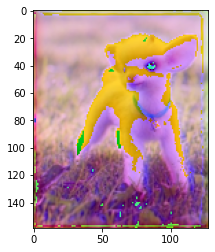

tensor(3.0125e+08, grad_fn=<AddBackward0>)
tensor(3.0005e+08, grad_fn=<AddBackward0>)
tensor(2.9887e+08, grad_fn=<AddBackward0>)
tensor(2.9769e+08, grad_fn=<AddBackward0>)
tensor(2.9652e+08, grad_fn=<AddBackward0>)
tensor(2.9535e+08, grad_fn=<AddBackward0>)
tensor(2.9420e+08, grad_fn=<AddBackward0>)
tensor(2.9305e+08, grad_fn=<AddBackward0>)
tensor(2.9191e+08, grad_fn=<AddBackward0>)
tensor(2.9078e+08, grad_fn=<AddBackward0>)
tensor(2.8966e+08, grad_fn=<AddBackward0>)
tensor(2.8854e+08, grad_fn=<AddBackward0>)
tensor(2.8743e+08, grad_fn=<AddBackward0>)
tensor(2.8633e+08, grad_fn=<AddBackward0>)
tensor(2.8524e+08, grad_fn=<AddBackward0>)
tensor(2.8416e+08, grad_fn=<AddBackward0>)
tensor(2.8308e+08, grad_fn=<AddBackward0>)
tensor(2.8201e+08, grad_fn=<AddBackward0>)
tensor(2.8095e+08, grad_fn=<AddBackward0>)
tensor(2.7990e+08, grad_fn=<AddBackward0>)


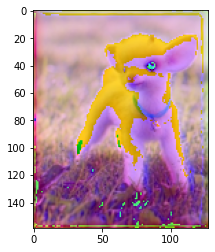

tensor(2.7885e+08, grad_fn=<AddBackward0>)
tensor(2.7781e+08, grad_fn=<AddBackward0>)
tensor(2.7678e+08, grad_fn=<AddBackward0>)
tensor(2.7576e+08, grad_fn=<AddBackward0>)
tensor(2.7475e+08, grad_fn=<AddBackward0>)
tensor(2.7374e+08, grad_fn=<AddBackward0>)
tensor(2.7274e+08, grad_fn=<AddBackward0>)
tensor(2.7175e+08, grad_fn=<AddBackward0>)
tensor(2.7076e+08, grad_fn=<AddBackward0>)
tensor(2.6979e+08, grad_fn=<AddBackward0>)
tensor(2.6882e+08, grad_fn=<AddBackward0>)
tensor(2.6786e+08, grad_fn=<AddBackward0>)
tensor(2.6690e+08, grad_fn=<AddBackward0>)
tensor(2.6596e+08, grad_fn=<AddBackward0>)
tensor(2.6502e+08, grad_fn=<AddBackward0>)
tensor(2.6409e+08, grad_fn=<AddBackward0>)
tensor(2.6316e+08, grad_fn=<AddBackward0>)
tensor(2.6225e+08, grad_fn=<AddBackward0>)
tensor(2.6134e+08, grad_fn=<AddBackward0>)
tensor(2.6044e+08, grad_fn=<AddBackward0>)


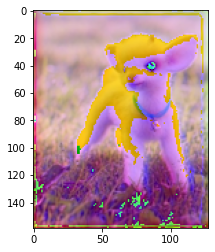

tensor(2.5954e+08, grad_fn=<AddBackward0>)
tensor(2.5866e+08, grad_fn=<AddBackward0>)
tensor(2.5778e+08, grad_fn=<AddBackward0>)
tensor(2.5690e+08, grad_fn=<AddBackward0>)
tensor(2.5604e+08, grad_fn=<AddBackward0>)
tensor(2.5518e+08, grad_fn=<AddBackward0>)
tensor(2.5433e+08, grad_fn=<AddBackward0>)
tensor(2.5349e+08, grad_fn=<AddBackward0>)
tensor(2.5265e+08, grad_fn=<AddBackward0>)
tensor(2.5182e+08, grad_fn=<AddBackward0>)
tensor(2.5100e+08, grad_fn=<AddBackward0>)
tensor(2.5018e+08, grad_fn=<AddBackward0>)
tensor(2.4938e+08, grad_fn=<AddBackward0>)
tensor(2.4857e+08, grad_fn=<AddBackward0>)
tensor(2.4778e+08, grad_fn=<AddBackward0>)
tensor(2.4699e+08, grad_fn=<AddBackward0>)
tensor(2.4621e+08, grad_fn=<AddBackward0>)
tensor(2.4544e+08, grad_fn=<AddBackward0>)
tensor(2.4467e+08, grad_fn=<AddBackward0>)
tensor(2.4391e+08, grad_fn=<AddBackward0>)


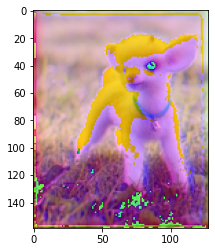

tensor(2.4316e+08, grad_fn=<AddBackward0>)
tensor(2.4241e+08, grad_fn=<AddBackward0>)
tensor(2.4167e+08, grad_fn=<AddBackward0>)
tensor(2.4094e+08, grad_fn=<AddBackward0>)
tensor(2.4021e+08, grad_fn=<AddBackward0>)
tensor(2.3949e+08, grad_fn=<AddBackward0>)
tensor(2.3877e+08, grad_fn=<AddBackward0>)
tensor(2.3807e+08, grad_fn=<AddBackward0>)
tensor(2.3736e+08, grad_fn=<AddBackward0>)
tensor(2.3667e+08, grad_fn=<AddBackward0>)
tensor(2.3598e+08, grad_fn=<AddBackward0>)
tensor(2.3530e+08, grad_fn=<AddBackward0>)
tensor(2.3462e+08, grad_fn=<AddBackward0>)
tensor(2.3395e+08, grad_fn=<AddBackward0>)
tensor(2.3329e+08, grad_fn=<AddBackward0>)
tensor(2.3263e+08, grad_fn=<AddBackward0>)
tensor(2.3198e+08, grad_fn=<AddBackward0>)
tensor(2.3133e+08, grad_fn=<AddBackward0>)
tensor(2.3069e+08, grad_fn=<AddBackward0>)
tensor(2.3005e+08, grad_fn=<AddBackward0>)


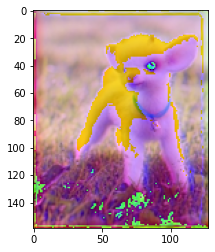

tensor(2.2943e+08, grad_fn=<AddBackward0>)
tensor(2.2880e+08, grad_fn=<AddBackward0>)
tensor(2.2819e+08, grad_fn=<AddBackward0>)
tensor(2.2758e+08, grad_fn=<AddBackward0>)
tensor(2.2697e+08, grad_fn=<AddBackward0>)
tensor(2.2637e+08, grad_fn=<AddBackward0>)
tensor(2.2578e+08, grad_fn=<AddBackward0>)
tensor(2.2519e+08, grad_fn=<AddBackward0>)
tensor(2.2460e+08, grad_fn=<AddBackward0>)
tensor(2.2403e+08, grad_fn=<AddBackward0>)
tensor(2.2345e+08, grad_fn=<AddBackward0>)
tensor(2.2289e+08, grad_fn=<AddBackward0>)
tensor(2.2232e+08, grad_fn=<AddBackward0>)
tensor(2.2177e+08, grad_fn=<AddBackward0>)
tensor(2.2122e+08, grad_fn=<AddBackward0>)
tensor(2.2067e+08, grad_fn=<AddBackward0>)
tensor(2.2013e+08, grad_fn=<AddBackward0>)
tensor(2.1959e+08, grad_fn=<AddBackward0>)
tensor(2.1906e+08, grad_fn=<AddBackward0>)
tensor(2.1854e+08, grad_fn=<AddBackward0>)


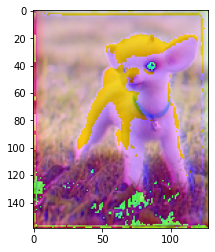

tensor(2.1801e+08, grad_fn=<AddBackward0>)
tensor(2.1750e+08, grad_fn=<AddBackward0>)
tensor(2.1699e+08, grad_fn=<AddBackward0>)
tensor(2.1648e+08, grad_fn=<AddBackward0>)
tensor(2.1598e+08, grad_fn=<AddBackward0>)
tensor(2.1548e+08, grad_fn=<AddBackward0>)
tensor(2.1499e+08, grad_fn=<AddBackward0>)
tensor(2.1450e+08, grad_fn=<AddBackward0>)
tensor(2.1402e+08, grad_fn=<AddBackward0>)
tensor(2.1354e+08, grad_fn=<AddBackward0>)
tensor(2.1307e+08, grad_fn=<AddBackward0>)
tensor(2.1260e+08, grad_fn=<AddBackward0>)
tensor(2.1213e+08, grad_fn=<AddBackward0>)
tensor(2.1167e+08, grad_fn=<AddBackward0>)
tensor(2.1122e+08, grad_fn=<AddBackward0>)
tensor(2.1076e+08, grad_fn=<AddBackward0>)
tensor(2.1032e+08, grad_fn=<AddBackward0>)
tensor(2.0987e+08, grad_fn=<AddBackward0>)
tensor(2.0943e+08, grad_fn=<AddBackward0>)
tensor(2.0900e+08, grad_fn=<AddBackward0>)


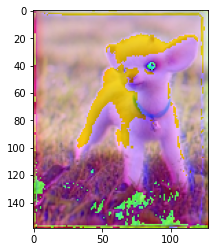

tensor(2.0857e+08, grad_fn=<AddBackward0>)
tensor(2.0814e+08, grad_fn=<AddBackward0>)
tensor(2.0772e+08, grad_fn=<AddBackward0>)
tensor(2.0730e+08, grad_fn=<AddBackward0>)
tensor(2.0688e+08, grad_fn=<AddBackward0>)
tensor(2.0647e+08, grad_fn=<AddBackward0>)
tensor(2.0606e+08, grad_fn=<AddBackward0>)
tensor(2.0566e+08, grad_fn=<AddBackward0>)
tensor(2.0526e+08, grad_fn=<AddBackward0>)
tensor(2.0486e+08, grad_fn=<AddBackward0>)
tensor(2.0447e+08, grad_fn=<AddBackward0>)
tensor(2.0408e+08, grad_fn=<AddBackward0>)
tensor(2.0370e+08, grad_fn=<AddBackward0>)
tensor(2.0332e+08, grad_fn=<AddBackward0>)
tensor(2.0294e+08, grad_fn=<AddBackward0>)
tensor(2.0256e+08, grad_fn=<AddBackward0>)
tensor(2.0219e+08, grad_fn=<AddBackward0>)
tensor(2.0182e+08, grad_fn=<AddBackward0>)
tensor(2.0146e+08, grad_fn=<AddBackward0>)
tensor(2.0110e+08, grad_fn=<AddBackward0>)


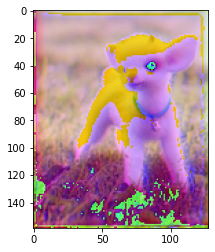

tensor(2.0074e+08, grad_fn=<AddBackward0>)
tensor(2.0039e+08, grad_fn=<AddBackward0>)
tensor(2.0003e+08, grad_fn=<AddBackward0>)
tensor(1.9969e+08, grad_fn=<AddBackward0>)
tensor(1.9934e+08, grad_fn=<AddBackward0>)
tensor(1.9900e+08, grad_fn=<AddBackward0>)
tensor(1.9866e+08, grad_fn=<AddBackward0>)
tensor(1.9833e+08, grad_fn=<AddBackward0>)
tensor(1.9799e+08, grad_fn=<AddBackward0>)
tensor(1.9766e+08, grad_fn=<AddBackward0>)
tensor(1.9734e+08, grad_fn=<AddBackward0>)
tensor(1.9701e+08, grad_fn=<AddBackward0>)
tensor(1.9669e+08, grad_fn=<AddBackward0>)
tensor(1.9637e+08, grad_fn=<AddBackward0>)
tensor(1.9606e+08, grad_fn=<AddBackward0>)
tensor(1.9575e+08, grad_fn=<AddBackward0>)
tensor(1.9544e+08, grad_fn=<AddBackward0>)
tensor(1.9513e+08, grad_fn=<AddBackward0>)
tensor(1.9483e+08, grad_fn=<AddBackward0>)
tensor(1.9453e+08, grad_fn=<AddBackward0>)


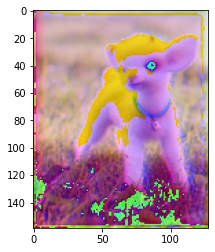

tensor(1.9423e+08, grad_fn=<AddBackward0>)
tensor(1.9393e+08, grad_fn=<AddBackward0>)
tensor(1.9364e+08, grad_fn=<AddBackward0>)
tensor(1.9335e+08, grad_fn=<AddBackward0>)
tensor(1.9306e+08, grad_fn=<AddBackward0>)
tensor(1.9277e+08, grad_fn=<AddBackward0>)
tensor(1.9249e+08, grad_fn=<AddBackward0>)
tensor(1.9221e+08, grad_fn=<AddBackward0>)
tensor(1.9193e+08, grad_fn=<AddBackward0>)
tensor(1.9165e+08, grad_fn=<AddBackward0>)
tensor(1.9138e+08, grad_fn=<AddBackward0>)
tensor(1.9111e+08, grad_fn=<AddBackward0>)
tensor(1.9084e+08, grad_fn=<AddBackward0>)
tensor(1.9057e+08, grad_fn=<AddBackward0>)
tensor(1.9031e+08, grad_fn=<AddBackward0>)
tensor(1.9005e+08, grad_fn=<AddBackward0>)
tensor(1.8979e+08, grad_fn=<AddBackward0>)
tensor(1.8953e+08, grad_fn=<AddBackward0>)
tensor(1.8927e+08, grad_fn=<AddBackward0>)
tensor(1.8902e+08, grad_fn=<AddBackward0>)


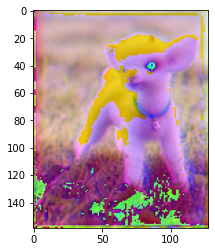

tensor(1.8877e+08, grad_fn=<AddBackward0>)
tensor(1.8852e+08, grad_fn=<AddBackward0>)
tensor(1.8827e+08, grad_fn=<AddBackward0>)
tensor(1.8803e+08, grad_fn=<AddBackward0>)
tensor(1.8778e+08, grad_fn=<AddBackward0>)
tensor(1.8754e+08, grad_fn=<AddBackward0>)
tensor(1.8730e+08, grad_fn=<AddBackward0>)
tensor(1.8707e+08, grad_fn=<AddBackward0>)
tensor(1.8683e+08, grad_fn=<AddBackward0>)
tensor(1.8660e+08, grad_fn=<AddBackward0>)
tensor(1.8637e+08, grad_fn=<AddBackward0>)
tensor(1.8614e+08, grad_fn=<AddBackward0>)
tensor(1.8591e+08, grad_fn=<AddBackward0>)
tensor(1.8568e+08, grad_fn=<AddBackward0>)
tensor(1.8546e+08, grad_fn=<AddBackward0>)
tensor(1.8524e+08, grad_fn=<AddBackward0>)
tensor(1.8502e+08, grad_fn=<AddBackward0>)
tensor(1.8480e+08, grad_fn=<AddBackward0>)
tensor(1.8458e+08, grad_fn=<AddBackward0>)
tensor(1.8437e+08, grad_fn=<AddBackward0>)


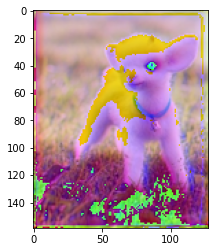

tensor(1.8415e+08, grad_fn=<AddBackward0>)
tensor(1.8394e+08, grad_fn=<AddBackward0>)
tensor(1.8373e+08, grad_fn=<AddBackward0>)
tensor(1.8352e+08, grad_fn=<AddBackward0>)
tensor(1.8332e+08, grad_fn=<AddBackward0>)
tensor(1.8311e+08, grad_fn=<AddBackward0>)
tensor(1.8291e+08, grad_fn=<AddBackward0>)
tensor(1.8270e+08, grad_fn=<AddBackward0>)
tensor(1.8250e+08, grad_fn=<AddBackward0>)
tensor(1.8230e+08, grad_fn=<AddBackward0>)
tensor(1.8211e+08, grad_fn=<AddBackward0>)
tensor(1.8191e+08, grad_fn=<AddBackward0>)
tensor(1.8172e+08, grad_fn=<AddBackward0>)
tensor(1.8152e+08, grad_fn=<AddBackward0>)
tensor(1.8133e+08, grad_fn=<AddBackward0>)
tensor(1.8114e+08, grad_fn=<AddBackward0>)
tensor(1.8095e+08, grad_fn=<AddBackward0>)
tensor(1.8077e+08, grad_fn=<AddBackward0>)
tensor(1.8058e+08, grad_fn=<AddBackward0>)
tensor(1.8040e+08, grad_fn=<AddBackward0>)


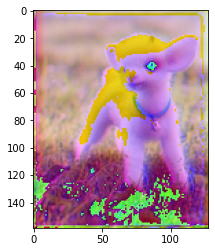

tensor(1.8021e+08, grad_fn=<AddBackward0>)
tensor(1.8003e+08, grad_fn=<AddBackward0>)
tensor(1.7985e+08, grad_fn=<AddBackward0>)
tensor(1.7967e+08, grad_fn=<AddBackward0>)
tensor(1.7949e+08, grad_fn=<AddBackward0>)
tensor(1.7932e+08, grad_fn=<AddBackward0>)
tensor(1.7914e+08, grad_fn=<AddBackward0>)
tensor(1.7897e+08, grad_fn=<AddBackward0>)
tensor(1.7880e+08, grad_fn=<AddBackward0>)
tensor(1.7862e+08, grad_fn=<AddBackward0>)
tensor(1.7845e+08, grad_fn=<AddBackward0>)
tensor(1.7828e+08, grad_fn=<AddBackward0>)
tensor(1.7812e+08, grad_fn=<AddBackward0>)
tensor(1.7795e+08, grad_fn=<AddBackward0>)
tensor(1.7779e+08, grad_fn=<AddBackward0>)
tensor(1.7762e+08, grad_fn=<AddBackward0>)
tensor(1.7746e+08, grad_fn=<AddBackward0>)
tensor(1.7730e+08, grad_fn=<AddBackward0>)
tensor(1.7714e+08, grad_fn=<AddBackward0>)
tensor(1.7698e+08, grad_fn=<AddBackward0>)


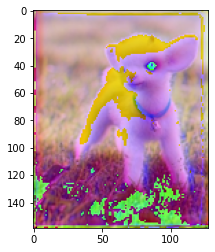

tensor(1.7682e+08, grad_fn=<AddBackward0>)
tensor(1.7666e+08, grad_fn=<AddBackward0>)
tensor(1.7650e+08, grad_fn=<AddBackward0>)
tensor(1.7635e+08, grad_fn=<AddBackward0>)
tensor(1.7620e+08, grad_fn=<AddBackward0>)
tensor(1.7604e+08, grad_fn=<AddBackward0>)
tensor(1.7589e+08, grad_fn=<AddBackward0>)
tensor(1.7574e+08, grad_fn=<AddBackward0>)
tensor(1.7559e+08, grad_fn=<AddBackward0>)
tensor(1.7544e+08, grad_fn=<AddBackward0>)
tensor(1.7529e+08, grad_fn=<AddBackward0>)
tensor(1.7515e+08, grad_fn=<AddBackward0>)
tensor(1.7500e+08, grad_fn=<AddBackward0>)
tensor(1.7486e+08, grad_fn=<AddBackward0>)
tensor(1.7471e+08, grad_fn=<AddBackward0>)
tensor(1.7457e+08, grad_fn=<AddBackward0>)
tensor(1.7443e+08, grad_fn=<AddBackward0>)
tensor(1.7429e+08, grad_fn=<AddBackward0>)
tensor(1.7415e+08, grad_fn=<AddBackward0>)
tensor(1.7401e+08, grad_fn=<AddBackward0>)


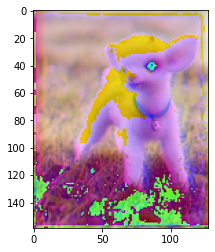

tensor(1.7387e+08, grad_fn=<AddBackward0>)
tensor(1.7373e+08, grad_fn=<AddBackward0>)
tensor(1.7360e+08, grad_fn=<AddBackward0>)
tensor(1.7346e+08, grad_fn=<AddBackward0>)
tensor(1.7333e+08, grad_fn=<AddBackward0>)
tensor(1.7319e+08, grad_fn=<AddBackward0>)
tensor(1.7306e+08, grad_fn=<AddBackward0>)
tensor(1.7293e+08, grad_fn=<AddBackward0>)
tensor(1.7280e+08, grad_fn=<AddBackward0>)
tensor(1.7267e+08, grad_fn=<AddBackward0>)
tensor(1.7254e+08, grad_fn=<AddBackward0>)
tensor(1.7241e+08, grad_fn=<AddBackward0>)
tensor(1.7228e+08, grad_fn=<AddBackward0>)
tensor(1.7215e+08, grad_fn=<AddBackward0>)
tensor(1.7203e+08, grad_fn=<AddBackward0>)
tensor(1.7190e+08, grad_fn=<AddBackward0>)
tensor(1.7178e+08, grad_fn=<AddBackward0>)
tensor(1.7165e+08, grad_fn=<AddBackward0>)
tensor(1.7153e+08, grad_fn=<AddBackward0>)
tensor(1.7141e+08, grad_fn=<AddBackward0>)


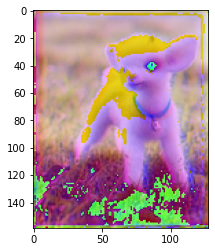

tensor(1.7129e+08, grad_fn=<AddBackward0>)
tensor(1.7117e+08, grad_fn=<AddBackward0>)
tensor(1.7105e+08, grad_fn=<AddBackward0>)
tensor(1.7093e+08, grad_fn=<AddBackward0>)
tensor(1.7081e+08, grad_fn=<AddBackward0>)
tensor(1.7069e+08, grad_fn=<AddBackward0>)
tensor(1.7058e+08, grad_fn=<AddBackward0>)
tensor(1.7046e+08, grad_fn=<AddBackward0>)
tensor(1.7034e+08, grad_fn=<AddBackward0>)
tensor(1.7023e+08, grad_fn=<AddBackward0>)
tensor(1.7012e+08, grad_fn=<AddBackward0>)
tensor(1.7000e+08, grad_fn=<AddBackward0>)
tensor(1.6989e+08, grad_fn=<AddBackward0>)
tensor(1.6978e+08, grad_fn=<AddBackward0>)
tensor(1.6967e+08, grad_fn=<AddBackward0>)
tensor(1.6956e+08, grad_fn=<AddBackward0>)
tensor(1.6945e+08, grad_fn=<AddBackward0>)
tensor(1.6934e+08, grad_fn=<AddBackward0>)
tensor(1.6923e+08, grad_fn=<AddBackward0>)
tensor(1.6912e+08, grad_fn=<AddBackward0>)


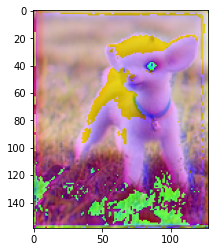

tensor(1.6901e+08, grad_fn=<AddBackward0>)
tensor(1.6891e+08, grad_fn=<AddBackward0>)
tensor(1.6880e+08, grad_fn=<AddBackward0>)
tensor(1.6870e+08, grad_fn=<AddBackward0>)
tensor(1.6859e+08, grad_fn=<AddBackward0>)
tensor(1.6849e+08, grad_fn=<AddBackward0>)
tensor(1.6839e+08, grad_fn=<AddBackward0>)
tensor(1.6828e+08, grad_fn=<AddBackward0>)
tensor(1.6818e+08, grad_fn=<AddBackward0>)
tensor(1.6808e+08, grad_fn=<AddBackward0>)
tensor(1.6798e+08, grad_fn=<AddBackward0>)
tensor(1.6788e+08, grad_fn=<AddBackward0>)
tensor(1.6778e+08, grad_fn=<AddBackward0>)
tensor(1.6768e+08, grad_fn=<AddBackward0>)
tensor(1.6758e+08, grad_fn=<AddBackward0>)
tensor(1.6748e+08, grad_fn=<AddBackward0>)
tensor(1.6739e+08, grad_fn=<AddBackward0>)
tensor(1.6729e+08, grad_fn=<AddBackward0>)
tensor(1.6719e+08, grad_fn=<AddBackward0>)
tensor(1.6710e+08, grad_fn=<AddBackward0>)


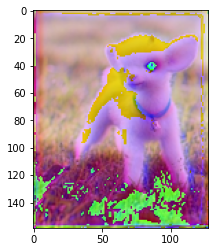

tensor(1.6700e+08, grad_fn=<AddBackward0>)
tensor(1.6691e+08, grad_fn=<AddBackward0>)
tensor(1.6681e+08, grad_fn=<AddBackward0>)
tensor(1.6672e+08, grad_fn=<AddBackward0>)
tensor(1.6663e+08, grad_fn=<AddBackward0>)
tensor(1.6654e+08, grad_fn=<AddBackward0>)
tensor(1.6644e+08, grad_fn=<AddBackward0>)
tensor(1.6635e+08, grad_fn=<AddBackward0>)
tensor(1.6626e+08, grad_fn=<AddBackward0>)
tensor(1.6617e+08, grad_fn=<AddBackward0>)
tensor(1.6608e+08, grad_fn=<AddBackward0>)
tensor(1.6599e+08, grad_fn=<AddBackward0>)
tensor(1.6590e+08, grad_fn=<AddBackward0>)
tensor(1.6582e+08, grad_fn=<AddBackward0>)
tensor(1.6573e+08, grad_fn=<AddBackward0>)
tensor(1.6564e+08, grad_fn=<AddBackward0>)
tensor(1.6555e+08, grad_fn=<AddBackward0>)
tensor(1.6547e+08, grad_fn=<AddBackward0>)
tensor(1.6538e+08, grad_fn=<AddBackward0>)
tensor(1.6530e+08, grad_fn=<AddBackward0>)


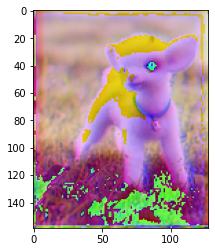

tensor(1.6521e+08, grad_fn=<AddBackward0>)
tensor(1.6513e+08, grad_fn=<AddBackward0>)
tensor(1.6504e+08, grad_fn=<AddBackward0>)
tensor(1.6496e+08, grad_fn=<AddBackward0>)
tensor(1.6488e+08, grad_fn=<AddBackward0>)
tensor(1.6480e+08, grad_fn=<AddBackward0>)
tensor(1.6471e+08, grad_fn=<AddBackward0>)
tensor(1.6463e+08, grad_fn=<AddBackward0>)
tensor(1.6455e+08, grad_fn=<AddBackward0>)
tensor(1.6447e+08, grad_fn=<AddBackward0>)
tensor(1.6439e+08, grad_fn=<AddBackward0>)
tensor(1.6431e+08, grad_fn=<AddBackward0>)
tensor(1.6423e+08, grad_fn=<AddBackward0>)
tensor(1.6415e+08, grad_fn=<AddBackward0>)
tensor(1.6408e+08, grad_fn=<AddBackward0>)
tensor(1.6400e+08, grad_fn=<AddBackward0>)
tensor(1.6392e+08, grad_fn=<AddBackward0>)
tensor(1.6384e+08, grad_fn=<AddBackward0>)
tensor(1.6377e+08, grad_fn=<AddBackward0>)
tensor(1.6369e+08, grad_fn=<AddBackward0>)


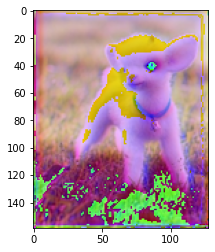

tensor(1.6362e+08, grad_fn=<AddBackward0>)
tensor(1.6354e+08, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [126]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
optimizer = optim.Adam([target], lr=0.01)
for i in range(2000):
    optimizer.zero_grad()
    target_features = get_features(target,vgg)
    content_features = get_features(content,vgg)
    style_features = get_features(style,vgg)
    
    contentLoss = calculateContent(target_features,content_features)
    
    style_grams = {layer: gramMatrix(style_features[layer]) for layer in style_features}
    target_grams = {layer: gramMatrix(target_features[layer]) for layer in target_features}
    
    styleLoss = calculateStyle(style_grams,target_grams,target_features,style_weights)
        
    totalLoss = 1*contentLoss + 1000*styleLoss
    
    totalLoss.backward()
    optimizer.step()
    if (i % 20 ==0):
        imageshow(target)
        plt.show()
    print(totalLoss)
        
        
        

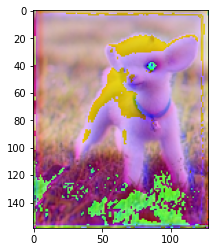

In [128]:
imageshow(target)

In [129]:
torch.save(target,"target.pt")